In [1]:
from casadi import *
import numpy as np
import matplotlib as plt
import seaborn as sn

In [2]:

#
from casadi import *

T = 20. # Time horizon
N = 40 # number of control intervals



def OCP(x_init, cost_function = "eco"):

    # Declare model variables
    x1 = MX.sym('x1')
    x2 = MX.sym('x2')
    x = vertcat(x1, x2)
    u = MX.sym('u')
    

    # Start with an empty NLP
    w=[]
    w0 = []
    lbw = []
    ubw = []
    J = 0
    g=[]
    lbg = []
    ubg = []

    # "Lift" initial conditions
    Xk = MX.sym('X0', 2)
    w += [Xk]
    lbw += x_init
    ubw += x_init
    w0 += x_init
        
    # Formulate the NLP
    for k in range(N):
        # New NLP variable for the control
        Uk = MX.sym('U_' + str(k))
        w   += [Uk]
        lbw += [-1]
        ubw += [1]
        w0  += [0]

        # Integrate till the end of the interval
        Xk_end_1 = 0.857*Xk[0] + 0.884*Xk[1] + 8.57*Uk
        Xk_end_2 = -0.0147*Xk[0] - 0.0151*Xk[1] + 0.884*Uk
        
        if cost_function == "eco":
            J += -3*Xk[0] -2*Xk[1]- 2*Uk
        else:
            J += 0.5*(2*(Xk[0]-60)**2+ 2*(Xk[1])**2 + 2*(Uk-1)**2)

        # New NLP variable for state at end of interval
        Xk = MX.sym('X_' + str(k+1), 2)
        w   += [Xk]
        lbw += [-inf, -inf]
        ubw += [ inf,  inf]
        w0  += [0, 0]

        # Add equality constraint
        g   += [Xk_end_1-Xk[0], Xk_end_2-Xk[1]]
        lbg += [0, 0]
        ubg += [0, 0]
    

    # Create an NLP solver
    prob = {'f': J, 'x': vertcat(*w), 'g': vertcat(*g)}
    
    opts = {
            "verbose_init": False,
            "ipopt": {"print_level": 2},
            "print_time": False,
            }
    solver = nlpsol('solver', 'ipopt', prob, opts)

    # Solve the NLP
    sol = solver(x0=w0, lbx=lbw, ubx=ubw, lbg=lbg, ubg=ubg)
    w_opt = sol['x'].full().flatten()
    J_opt = sol['g'].full().flatten()

    # Plot the solution
    x1_opt = w_opt[0::3]
    x2_opt = w_opt[1::3]
    u_opt = w_opt[2::3]
    
    return [x1_opt[1],x2_opt[1]], u_opt[0]



In [3]:

def MPC():
    N = 40
    x_init = [80,10]
    
    x1_eco = [80]
    x2_eco = [10]
    u_eco = []
    x1_targ = [80]
    x2_targ = [10]
    u_targ = []
    eco_cost = 0
    targ_cost = 0
    for k in range(N):
        xk_eco, uk_eco = OCP([x1_eco[k], x2_eco[k]], cost_function = "eco")

        xk_targ, uk_targ = OCP([x1_targ[k], x2_targ[k]], cost_function = "targ")
        
        x1_eco.append(xk_eco[0])
        x2_eco.append(xk_eco[1])
        x1_targ.append(xk_targ[0])
        x2_targ.append(xk_targ[1])
        
        eco_cost += -3*xk_eco[0] - 2*xk_eco[1] -2*uk_eco
        targ_cost += -3*xk_targ[0] - 2*xk_targ[1] - 2*uk_targ
        
    return x1_eco, x2_eco, x1_targ, x2_targ
    

x1_eco, x2_eco, x1_targ, x2_targ = MPC()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

-7943.247523134371
-7472.745229273412


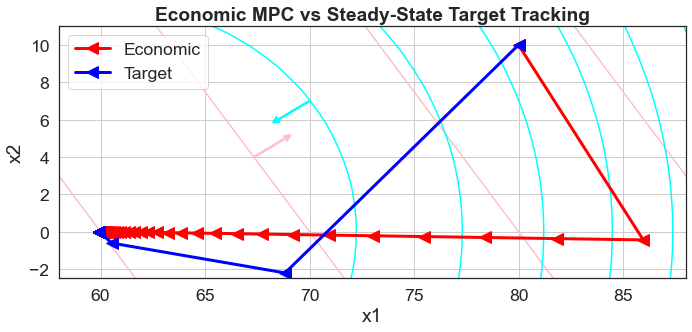

In [4]:
import matplotlib as matlib
import matplotlib.pyplot as plt
sn.set(style="white", font_scale= 1.6)
plt.figure(figsize = (10,5))

plt.clf()

delta = 50
x1 = np.arange(30, 90, (90-30)/delta)
x2 = np.arange(-5, 15, 20/delta)
X, Y = np.meshgrid(x1, x2)
Z1 = -3*X -2*Y
Z2 = 0.5*(2*(X-60)**2+ 2*(Y)**2)

matlib.rcParams['contour.negative_linestyle'] = 'solid'
plt.contour(X, Y, Z1, colors = "pink", alpha = 1)
plt.contour(X, Y, Z2, colors = "cyan", alpha = 1)


plt.plot(x1_eco, x2_eco, marker= "<", linewidth = 3, color = "red", markersize = 12)
plt.plot(x1_targ, x2_targ, marker = "<", linewidth = 3, color = "blue", markersize = 12)
plt.arrow(67.35, 4, 1.5,1 , head_width = 0.3, head_length = 0.3, fc ="pink", ec="pink", linewidth = 2)
plt.arrow(70, 7, -1.5, -1 , head_width = 0.3, head_length = 0.3, fc ="cyan", ec="cyan", linewidth = 2)


plt.xlabel('x1')
plt.ylabel('x2')
plt.legend(["Economic", "Target"])
plt.title("Economic MPC vs Steady-State Target Tracking", fontweight = "bold")
plt.grid()
plt.xlim([58, 88])
plt.ylim([-2.5, 11])
plt.tight_layout()
plt.savefig("../figs/eco_vs_steady.pdf", format="pdf")
plt.show()
